In [1]:
import numpy as np
import astra
import tomopy
import pylops
from matplotlib import pyplot as plt

import imwip

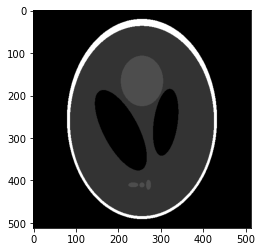

In [2]:
im_size = 512
shepp = tomopy.shepp2d(im_size)[0].astype(np.float32)/255
plt.imshow(shepp, cmap="gray")

Modelling the motion using a RigidMotionOperator2D:
$$
x =
\begin{bmatrix}
x_1 \\
x_2
\end{bmatrix}
=
\begin{bmatrix}
I \\
M(\theta, t)
\end{bmatrix}x_1
$$

In [3]:
true_trans = [50, -20]
true_rot = 0.3

I = pylops.Identity(im_size**2, dtype=np.dtype('float32'))
M_2 = lambda rot, trans: imwip.AffineWarpingOperator2D(
    (im_size, im_size),
    rotation=rot,
    translation=trans,
    adjoint_type="inverse")

M = lambda rot, trans: pylops.VStack([I,
                                      M_2(rot, trans)])

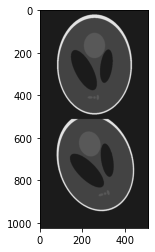

In [4]:
true_x = M(true_rot, true_trans) @ shepp.ravel()
plt.imshow(true_x.reshape(-1, im_size), cmap="gray")

CT system (astra): two subscans

In [5]:
vol_geom = astra.create_vol_geom(im_size, im_size)

angles_1 = np.linspace(0, np.pi, 100)[0::2]
angles_2 = np.linspace(0, np.pi, 100)[1::2]

proj_geom_1 = astra.create_proj_geom('parallel', 1, im_size, angles_1)
proj_id_1 = astra.create_projector('cuda', proj_geom_1, vol_geom)

proj_geom_2 = astra.create_proj_geom('parallel', 1, im_size, angles_2)
proj_id_2 = astra.create_projector('cuda', proj_geom_2, vol_geom)

The full dynamic CT system becomes
$$
\begin{bmatrix}
W_1 & 0\\
0 & W_2
\end{bmatrix}
\begin{bmatrix}
I \\
M_2(\theta, t)
\end{bmatrix}x_1
=
\begin{bmatrix}
p_1 \\
p_2
\end{bmatrix}
$$
or in short
$$
WM(\theta, t)x_1=p
$$

In [6]:
W_1 = astra.OpTomo(proj_id_1)
W_2 = astra.OpTomo(proj_id_2)
W = pylops.BlockDiag([W_1,
                           W_2])

(-0.5, 511.5, 99.5, -0.5)

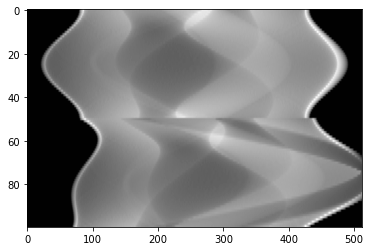

In [7]:
p = W @ M(true_rot, true_trans) @ shepp.ravel()
plt.imshow(p.reshape(-1, im_size), cmap="gray")
plt.axis('auto')

We can solve
$
WM(\theta, t)x=p
$
simultaniously for $\theta, t$ and $x$
by minimizing
$$ f(\theta, t, x) = \frac{1}{2}\lVert WM(\theta, t)x-p \rVert^2$$

In [8]:
# objective function
def f(x, rot, trans):
    rot = rot[0]
    res = W @ (M(rot, trans) @ x) - p
    return 1/2 * np.dot(res, res)

More important or the solver is the gradient of this objective function:
$$
\begin{aligned}
\nabla_{\theta, t} f(\theta, t, x) &= \left(\frac{d}{d(\theta, t)} M(\theta, t)x\right)^T&W^T(WM(\theta, t)x-p)\\
\nabla_x f(\theta, t, x) &= M(\theta, t)^T&W^T(WM(\theta, t)x-p)
\end{aligned}
$$

In [9]:
# gradient of objective function
def grad_f(x, rot, trans):
    rot = rot[0]

    WTres = W.T @ (W @ (M(rot, trans) @ x) - p)

    grad_rot, grad_trans = imwip.diff(M(rot, trans), x, to=["rot", "trans"])
    grad_rot = grad_rot.T @ WTres
    grad_trans = grad_trans.T @WTres

    grad_x = M(rot, trans).T @ WTres

    return grad_x, grad_rot, grad_trans

In [10]:
# initial guess: zero
rot0 = [0.0]
trans0 = [0.0, 0.0]
x0 = np.zeros(im_size**2, dtype=np.float32)

In [11]:
# solve
x, rot, trans = imwip.split_barzilai_borwein(
    grad_f,
    x0=(x0, rot0, trans0),
    bounds=((0, 1), None, None),
    max_iter=200,
    verbose=True)

100%|█████████████████████████████████████████| 200/200 [00:02<00:00, 66.88it/s]


In [12]:
print("estimated rotation:", rot)
print("true rotation:", true_rot)
print()
print("estimated translation:", trans)
print("true translation:", true_trans)

estimated rotation: [0.29716822]
true rotation: 0.3

estimated translation: [ 50.01833005 -19.8080992 ]
true translation: [50, -20]


Solution in first subscan:

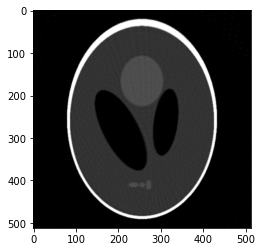

In [13]:
plt.imshow(x.reshape((-1, im_size)), cmap="gray")

Solution in second subscan

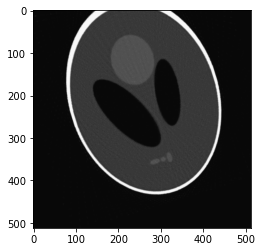

In [14]:
plt.imshow((M_2(rot[0], trans) @ x).reshape((-1, im_size)), cmap="gray")